In [ ]:
pip install pandas numpy scikit-learn nltk transformers sentence-transformers pdfminer.six faiss-cpu matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [ ]:
import re
import pandas as pd
import numpy as np
import os
from pdfminer.high_level import extract_text
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import ast
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Initialize the sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def extract_text_from_pdf(pdf_path):
    try:
        return extract_text(pdf_path)
    except Exception as e:
        print(f"Error extracting text from PDF ({pdf_path}): {e}")
        return ""

In [ ]:
def clean_text(text):
    # Basic text cleaning.
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # Removing punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Removing extra whitespace
    return text

def preprocess_text(text):
    # Cleaning and removing stopwords.
    text = clean_text(text)
    stops = set(stopwords.words('english'))
    words = [word for word in text.split() if word not in stops and len(word) > 2]
    return ' '.join(words)

def tokenize_into_sentences(text):
    # Cleaning the text
    text = clean_text(text)
    # Splitting into sentences
    sentences = sent_tokenize(text)
    # Further cleaning each sentence
    sentences = [preprocess_text(sentence) for sentence in sentences if len(sentence) > 10]
    return sentences


In [ ]:
def get_section_text(text, section_name, next_sections):
    # Extracting text from a specific section until the next section starts.
    pattern = fr"(?i)(?:{section_name})\s*[:\-]*\s*(.*?)(?:(?:{next_sections})|$)"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""

def extract_resume_sections(text):
    # Defining section names and possible next sections for resumes
    sections = {
        "education": ["experience", "skills", "projects", "certifications", "achievements", "publications"],
        "experience": ["education", "skills", "projects", "certifications", "achievements", "publications"],
        "skills": ["education", "experience", "projects", "certifications", "achievements", "publications"],
        "projects": ["education", "experience", "skills", "certifications", "achievements", "publications"]
    }

    result = {}
    for section, next_sections in sections.items():
        next_sections_pattern = "|".join(next_sections)
        section_text = get_section_text(text, section, next_sections_pattern)
        result[section] = section_text

    return result

In [ ]:
def extract_job_sections(text):
    # Defining section names and possible next sections for job postings
    sections = {
        "responsibilities": ["requirements", "qualifications", "about", "benefits", "company"],
        "requirements": ["responsibilities", "qualifications", "about", "benefits", "company"],
        "qualifications": ["responsibilities", "requirements", "about", "benefits", "company"],
        "description": ["responsibilities", "requirements", "qualifications", "about", "benefits", "company"]
    }

    result = {}
    for section, next_sections in sections.items():
        next_sections_pattern = "|".join(next_sections)
        section_text = get_section_text(text, section, next_sections_pattern)
        result[section] = section_text

    # If unable to find structured sections, using the whole text
    if all(not value for value in result.values()):
        result["full_text"] = text

    return result

In [ ]:
def get_document_embedding(sentences):
    if not sentences:
        return np.zeros(384)  # Default embedding dimension for this model

    # Getting embeddings for each sentence
    embeddings = model.encode(sentences)

    # Averaging the embeddings for the resume as a whole
    return np.mean(embeddings, axis=0)

In [ ]:
def create_resume_embeddings(resume_files):
    resume_data = []

    for file in tqdm(resume_files, desc="Processing resumes"):
        text = extract_text_from_pdf(file)
        if not text:
            continue

        # Extracting sections
        sections = extract_resume_sections(text)
        section_embeddings = {}

        # Processing each section
        for section_name, section_text in sections.items():
            if section_text:
                sentences = tokenize_into_sentences(section_text)
                section_embeddings[f"{section_name}_embedding"] = get_document_embedding(sentences)

        # Processing full text
        all_sentences = tokenize_into_sentences(text)

        resume_data.append({
            "filename": file,
            "raw_text": text,
            "sections": sections,
            "sentences": all_sentences,
            "full_embedding": get_document_embedding(all_sentences),
            **section_embeddings  # Adding section-specific embeddings
        })

    return resume_data

In [ ]:
def create_job_embeddings(jobs_df):
    job_data = []

    for _, row in tqdm(jobs_df.iterrows(), total=len(jobs_df), desc="Processing jobs"):
        job_title = row.get('Job Title', row.get('title', ''))
        job_desc = row.get('description', row.get('Job Description', ''))

        if not job_desc:
            continue

        # Extracting sections if possible
        sections = extract_job_sections(job_desc)
        section_embeddings = {}

        # Processing each section
        for section_name, section_text in sections.items():
            if section_text:
                sentences = tokenize_into_sentences(section_text)
                section_embeddings[f"{section_name}_embedding"] = get_document_embedding(sentences)

        # Processing full text
        all_sentences = tokenize_into_sentences(job_desc)

        job_data.append({
            "job_id": row.get('id', row.get('Job ID', len(job_data))),
            "job_title": job_title,
            "raw_text": job_desc,
            "sections": sections,
            "sentences": all_sentences,
            "full_embedding": get_document_embedding(all_sentences),
            **section_embeddings  # Adding section-specific embeddings
        })

    return job_data


In [ ]:
def build_faiss_index(embeddings):
    # Converting to numpy array
    vectors = np.array(embeddings).astype('float32')

    # Creating an index
    dimension = vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(vectors)

    return index

In [ ]:
def match_resume_to_jobs(resume_embedding, job_data, job_embeddings_index, k=10):
    # Converting embedding to proper format
    query_vector = np.array([resume_embedding]).astype('float32')

    # Searching the index
    distances, indices = job_embeddings_index.search(query_vector, k)

    # Getting the matching jobs
    matches = []
    for i, idx in enumerate(indices[0]):
        if idx < len(job_data):  # Safeguarding against index out of bounds
            matches.append({
                "job_id": job_data[idx]["job_id"],
                "job_title": job_data[idx]["job_title"],
                "similarity_score": 1 / (1 + distances[0][i]),  # Converting the distance to similarity score
                "raw_text": job_data[idx]["raw_text"]
            })

    return matches


In [ ]:
def match_job_to_resumes(job_embedding, resume_data, resume_embeddings_index, k=10):
    # Converting embedding to proper format
    query_vector = np.array([job_embedding]).astype('float32')

    # Searching the index
    distances, indices = resume_embeddings_index.search(query_vector, k)

    # Getting the matching resumes
    matches = []
    for i, idx in enumerate(indices[0]):
        if idx < len(resume_data):  # Safeguarding against index out of bounds
            matches.append({
                "filename": resume_data[idx]["filename"],
                "similarity_score": 1 / (1 + distances[0][i]),  # Converting the distance to similarity score
                "raw_text": resume_data[idx]["raw_text"]
            })

    return matches

In [ ]:
def evaluate_model(test_data, resume_data, job_data, resume_embeddings_index, job_embeddings_index):
    top_1_correct = 0
    top_5_correct = 0
    top_10_correct = 0
    total_pairs = len(test_data)

    for pair in test_data:
        resume_idx = pair["resume_idx"]
        job_idx = pair["job_idx"]

        # Getting resume embedding
        resume_embedding = resume_data[resume_idx]["full_embedding"]

        # Matching resume to jobs
        matches = match_resume_to_jobs(resume_embedding, job_data, job_embeddings_index, k=10)

        # Checking if the correct job is in top matches
        correct_job_id = job_data[job_idx]["job_id"]
        matched_job_ids = [match["job_id"] for match in matches]

        if correct_job_id == matched_job_ids[0]:
            top_1_correct += 1

        if correct_job_id in matched_job_ids[:5]:
            top_5_correct += 1

        if correct_job_id in matched_job_ids:
            top_10_correct += 1

    # Calculating accuracies
    top_1_accuracy = top_1_correct / total_pairs if total_pairs > 0 else 0
    top_5_accuracy = top_5_correct / total_pairs if total_pairs > 0 else 0
    top_10_accuracy = top_10_correct / total_pairs if total_pairs > 0 else 0

    return {
        "top_1_accuracy": top_1_accuracy,
        "top_5_accuracy": top_5_accuracy,
        "top_10_accuracy": top_10_accuracy
    }


In [ ]:
def visualize_matches(matches, title="Top Matching Jobs"):
    plt.figure(figsize=(10, 6))

    # Extracting job titles and scores
    job_titles = [match['job_title'][:30] + '...' if len(match['job_title']) > 30 else match['job_title']
                  for match in matches]
    scores = [match['similarity_score'] for match in matches]

    # Creating a horizontal bar chart
    sns.barplot(x=scores, y=job_titles)
    plt.title(title)
    plt.xlabel('Similarity Score')
    plt.ylabel('Job Title')
    plt.tight_layout()

In [ ]:
def main():
    # Loading resume files
    resume_files = [
        'nlp_1.pdf',
        'nlp_2.pdf',
        'nlp_3.pdf',
        'nlp_4.pdf'
    ]

    # Loading job descriptions
    jobs_df = pd.read_csv('job_title_des_nlp.csv')

    # Creating embeddings
    print("Creating resume embeddings...")
    resume_data = create_resume_embeddings(resume_files)

    print("Creating job embeddings...")
    job_data = create_job_embeddings(jobs_df)

    # Extracting vectors for indexing
    resume_embeddings = [data["full_embedding"] for data in resume_data]
    job_embeddings = [data["full_embedding"] for data in job_data]

    # Building FAISS indices
    print("Building FAISS indices...")
    resume_embeddings_index = build_faiss_index(resume_embeddings)
    job_embeddings_index = build_faiss_index(job_embeddings)

    # Matching a specific resume to jobs
    example_resume_idx = 0
    print(f"\nMatching resume {resume_data[example_resume_idx]['filename']} to jobs...")
    example_matches = match_resume_to_jobs(resume_data[example_resume_idx]["full_embedding"],
                                          job_data, job_embeddings_index)

    # Displaying top matches
    print("\nTop matching jobs:")
    for i, match in enumerate(example_matches[:5], 1):
        print(f"{i}. {match['job_title']} (Score: {match['similarity_score']:.4f})")

    # Visualizing matches
    visualize_matches(example_matches[:10])


Creating resume embeddings...


Processing resumes: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Creating job embeddings...


Processing jobs: 100%|██████████| 2277/2277 [06:40<00:00,  5.69it/s]


Building FAISS indices...

Matching resume nlp_1.pdf to jobs...

Top matching jobs:
1. Network Administrator (Score: 0.0853)
2. Network Administrator (Score: 0.0823)
3. Network Administrator (Score: 0.0811)
4. Network Administrator (Score: 0.0800)
5. Database Administrator (Score: 0.0749)


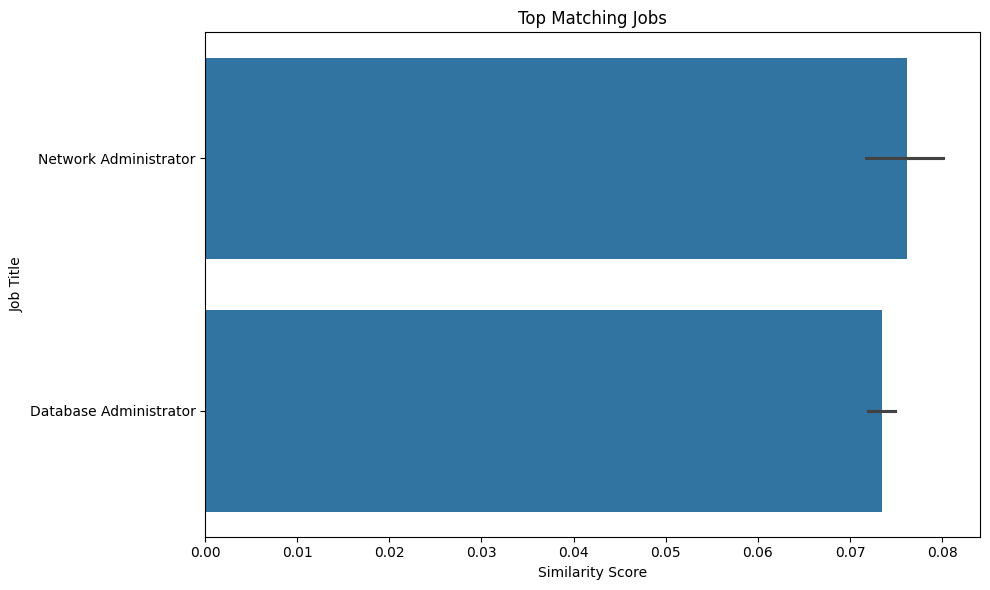

In [ ]:
if __name__ == "__main__":
    main()